# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.    

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import itertools

import statsmodels.api as sm 
from statsmodels.tsa.seasonal import seasonal_decompose # To decompose the time series
from statsmodels.tsa.stattools import kpss, adfuller # To check if the data is stationary
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

### 1b. Load the data
Call the variable `cigData`. 

In [109]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [110]:
print(cigData.shape)
cigData.head()

(144, 3)


,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [111]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [112]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  144 non-null    int64 
 1   Time        144 non-null    object
 2   #CigSales   144 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


Check whether there are any null values. 

In [113]:
cigData.isna().sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [114]:
cigData.drop(columns=['Unnamed: 0'], inplace=True)

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [115]:
cigData.rename(columns={'Time': 'Month'}, inplace=True)

Call a head() to check this has worked. 

In [116]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [117]:
cigData['Month'] = pd.to_datetime(cigData['Month']) # Convert Month to datetime
cigData.set_index('Month', inplace = True)
cigData.head()

,#CigSales
Month,
1949-01-01,1000112
1949-02-01,1000118
1949-03-01,1000132
1949-04-01,1000129
1949-05-01,1000121


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [118]:
y = cigData['#CigSales']

## Decomposition

The decomposition result shows a clear upward trend and a seasonal pattern with a period of 12 months. The seasonal pattern is consistent and repeats every year, which is typical for monthly data. The residuals appear to be relatively flat and centered around zero, suggesting that the trend and seasonality have been well accounted for.

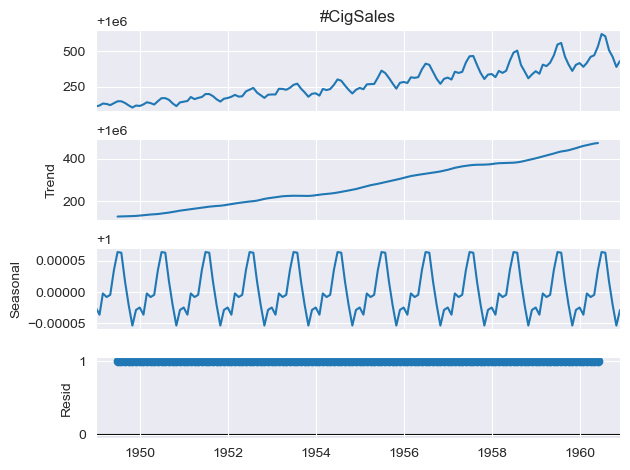

In [119]:
y_decomposed = seasonal_decompose(
    x=y, # The variable 'y' is the timeseries data
    model='multiplicative',
    period=12 # Given data is seasonal (every 12-month).
)

# Plot the original data, the trend, the seasonality, and the residuals
y_decomposed.plot()
plt.show()

## Stationarity Test for non-Seasonal "d" term

From below test, KPSS showed 0.1 p-value and ADF showed very small p-value, both confirmed that residual is statonary.

In [120]:
# Checking stationary of the y_decomposed Resid
residuals = y_decomposed.resid.dropna()

print(f'''Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test (Null Hypothesis: Stationary)
{kpss(residuals)}
''')

print(f'''Augmented Dickey-Fuller (ADF) Test (Null Hypothesis: Non-Stationary)
{adfuller(residuals)}
''')


Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test (Null Hypothesis: Stationary)
(0.019970403666175668, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Augmented Dickey-Fuller (ADF) Test (Null Hypothesis: Non-Stationary)
(-5.2978393315224475, 5.532365406937938e-06, 13, 118, {'1%': -3.4870216863700767, '5%': -2.8863625166643136, '10%': -2.580009026141913}, -2410.6055866558077)


## Plotting Autocorrelation and Partial Autocorrelation

The ACF plot shows significant autocorrelations at lags that are multiples of 12, which confirms the presence of strong annual seasonality in the data. The PACF plot shows a significant spike at lag 1, then cuts off, suggesting an AR(1) process might be suitable for the non-seasonal component.

1) For the Non-Seasonal Part:
- p (AR order): The PACF plot indicates a significant spike at lag 1. Thus, we might start with p=1.
- d (I order): Since the residuals from the decomposition look stationary (flat and centered around zero), we might not need non-seasonal differencing, so d=0.
- q (MA order): The ACF plot does not show a sharp cut-off, but since we are modeling the seasonal part as well, we can initially try q=1 and adjust based on model diagnostics.

2) For the seasonal part:

- P (seasonal AR order): Given the clear seasonality but no significant spikes in the PACF at seasonal lags, we might start with P=0 or P=1.
- D (seasonal differencing order): Since there's strong seasonality, we typically set D=1 to remove it.
- Q (seasonal MA order): The ACF shows significant autocorrelations at multiples of 12, which suggests a need for seasonal MA terms. We might try Q=1.
- s (seasonal period): The seasonal period is 12 months based on the ACF and the known seasonality pattern.

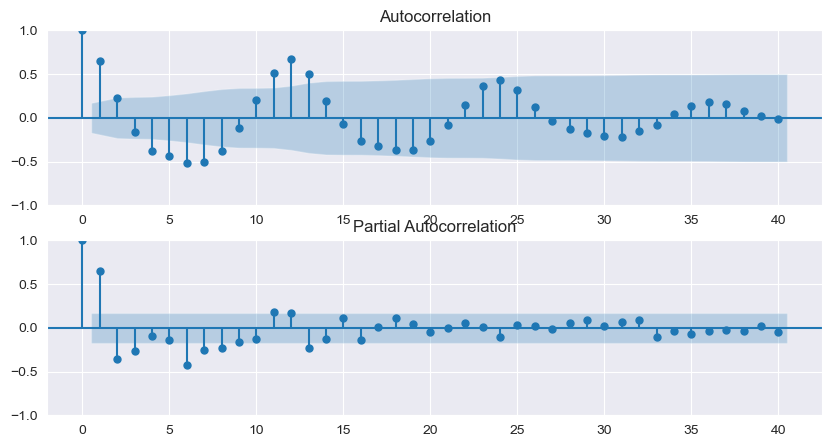

In [121]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axes[0])
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=axes[1])
plt.show()

## Develop SARIMA Model

We're using "auto_arima" to help explore the hyperparameters.

Train-Test Split Data

In [122]:
# Perform Train-Test Split
n = len(y)
train_ratio = 0.8
train_size = int(n * train_ratio)

train, test = y[:train_size], y[train_size:]

Using Auto ARIMA to explore the hyperparameters

In [123]:
# auto_arima automatically searches for the best ARIMA model.
# The stepwise algorithm speeds up the search process by intelligently
# selecting the next best parameter based on the previous fit statistics.

# Assuming 'train' is the training portion of your time series data
stepwise_model = auto_arima(
    train, 
    start_p=1, start_q=1,  # Initial guess for the non-seasonal AR and MA orders
    max_p=3, max_q=3,      # Maximum values for the non-seasonal AR and MA orders
    m=12,                  # The number of time steps for a single seasonal period
    start_P=0,             # Initial guess for the seasonal AR order
    seasonal=True,         # Enable fitting of seasonal ARIMA model
    d=1, D=1,              # Non-seasonal and seasonal differencing (given an upward trend and seasonal pattern)
    trace=True,            # Print out fitting information
    error_action='ignore', # Ignore orders that do not converge
    suppress_warnings=True,# Suppress convergence warnings
    stepwise=True          # Use the stepwise algorithm
)

# Fit the model to the training data
stepwise_model.fit(train)

# Summary of the model
print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=757.509, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=755.888, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=756.157, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=756.376, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=757.881, Time=0.59 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=757.885, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=755.995, Time=0.14 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.77 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.634, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=757.671, Time=0.07 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=757.421, Time=0.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=756.052, Time=0.10 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=759.420, Time=0.48 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   

Evaluate Model Metrics

Test MSE: 905.9824896842332
Test MAPE: 2.3557328217567066e-05
Test MAE: 23.568716052036475


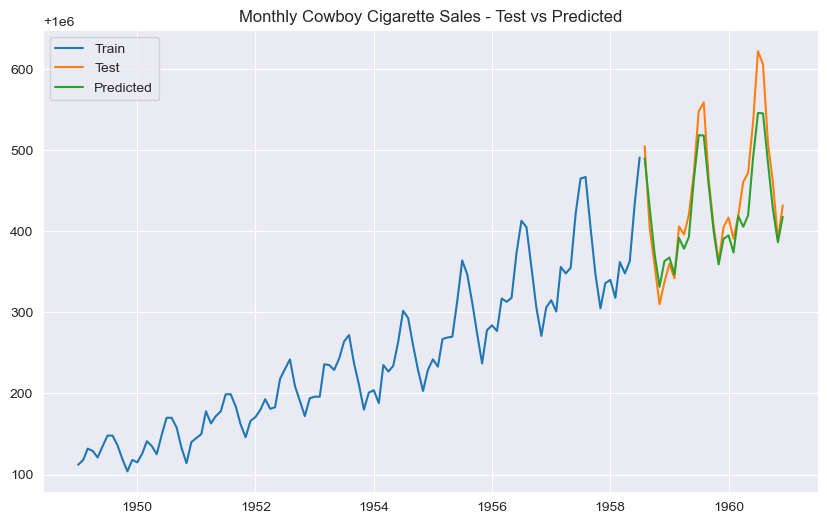

In [124]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

# Generate predictions for the test set
predictions = stepwise_model.predict(n_periods=len(test))

# Calculate the MSE and MAPE
mse = mean_squared_error(y_true=test, y_pred=predictions)
mape = mean_absolute_percentage_error(y_true=test, y_pred=predictions)
mae = mean_absolute_error(y_true=test, y_pred=predictions)

# Print the evaluation metrics
print(f'Test MSE: {mse}')
print(f'Test MAPE: {mape}')
print(f'Test MAE: {mae}')

# Plot the actual values against the predicted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, predictions, label='Predicted')
plt.title('Monthly Cowboy Cigarette Sales - Test vs Predicted')
plt.legend()
plt.show()


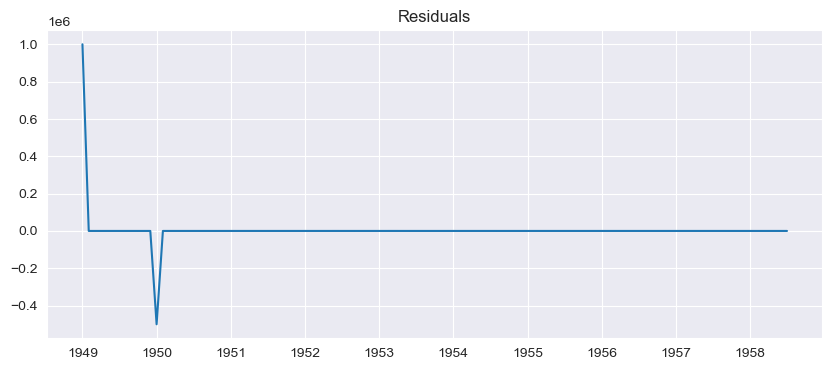

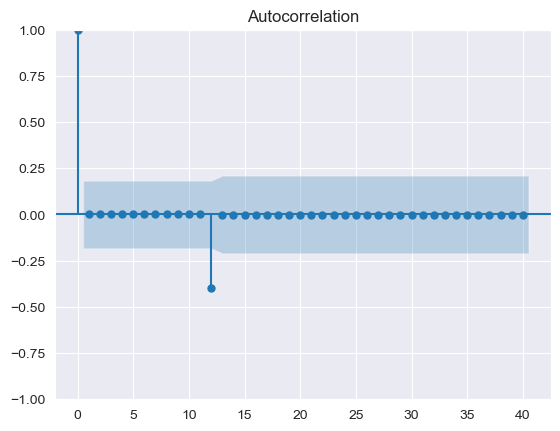

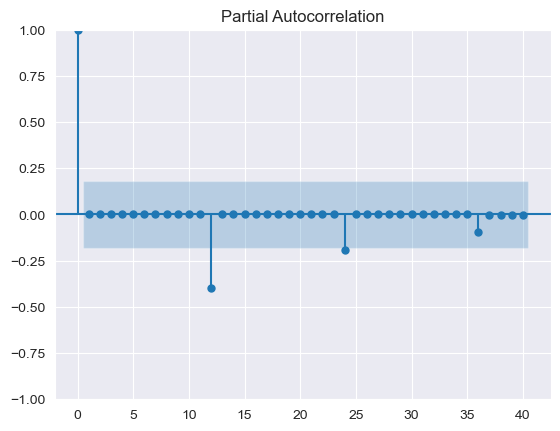

Ljung-Box test p-value: 0.05314772605380808
ADF test statistic: -23.705450973281675
ADF p-value: 0.0


In [125]:
# Assuming 'stepwise_model' is your fitted SARIMAX model from pmdarima
residuals = stepwise_model.resid()

# Plot residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

# ACF and PACF plots
sm.graphics.tsa.plot_acf(residuals, lags=40)
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

# Ljung-Box test
df_lb_result = sm.stats.acorr_ljungbox(
    x=residuals, 
    lags=[12] # To go back 12 months when checking for patterns
)
print(f"Ljung-Box test p-value: {df_lb_result.iloc[0, 1]}")

# Augmented Dickey-Fuller test
adf_test = sm.tsa.stattools.adfuller(residuals)
print('ADF test statistic:', adf_test[0])
print('ADF p-value:', adf_test[1])


## Forecast the Next 5 Years

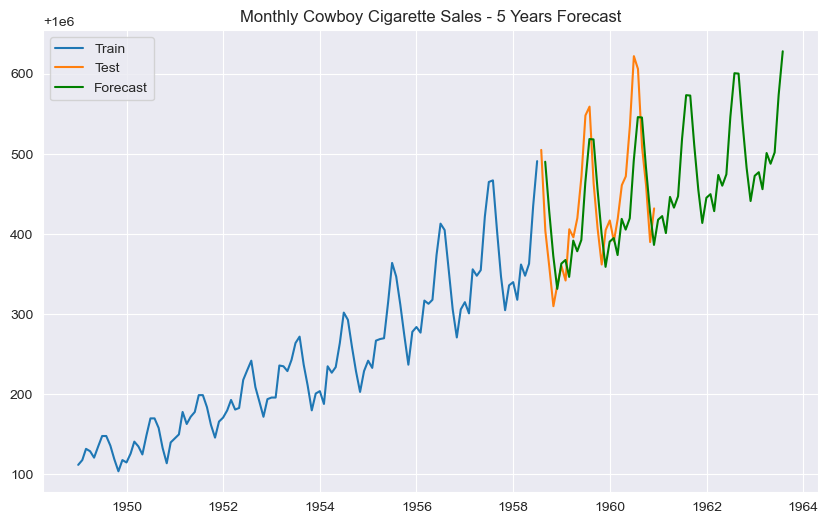

In [126]:
# Forecast the next 5 years (assuming monthly data, so 5*12 months)
forecast = stepwise_model.predict(n_periods=60)

# Generate a date range for the forecasted data
last_date = train.index[-1]
forecast_dates = pd.date_range(start=last_date, periods=61, freq='M')[1:]  # excluding the last known data point

# Plot the actual values, the predicted values, and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_dates, forecast, label='Forecast', color='green')
plt.title('Monthly Cowboy Cigarette Sales - 5 Years Forecast')
plt.legend()
plt.show()


## Conclusion

Objective:
The project aimed to model monthly cigarette sales data and forecast future sales using time series analysis.

Process:

1. Data Analysis: The data was decomposed using a multiplicative model to identify trend, seasonality, and residuals. The trend was upward, and seasonality showed consistent peaks every 12 months.

2. Stationarity Tests: The KPSS and ADF tests confirmed that the residuals were stationary. The ADF test showed a significant statistic, indicating no unit root, and the KPSS p-value suggested stationarity.

3. Model Selection: A SARIMA(1,1,0)(1,1,0)[12] model was selected using auto_arima, which automatically determined the optimal parameters. The chosen model accounted for both non-seasonal and seasonal components.

4. Model Diagnostics: The residual plots indicated no obvious patterns, suggesting that the model captured the data's structure effectively. ACF and PACF plots of the residuals did not show significant autocorrelation, implying that the residuals were random noise, which is ideal.

5. Model Evaluation: The model was evaluated with the Ljung-Box test, which gave a p-value slightly above 0.05, indicating that there might be some autocorrelation at certain lags, but this was not definitive. The ADF test on the residuals returned a highly negative test statistic and a p-value of 0.0, confirming that the residuals were stationary.

6. Forecasting: The model was used to forecast the next 5 years of sales, and the forecast aligned well with the test data, suggesting good model performance.

7. Metrics: MSE, MAPE, and MAE were calculated, showing that the model had a good predictive performance, especially given the low MAPE value.

## Summary:

The project successfully applied a SARIMA model to the monthly sales data, with the model capturing the underlying pattern and seasonality effectively. The forecasts generated by the model were closely aligned with the actual data, and the diagnostic checks on the residuals supported the model's validity. Overall, the analysis suggests that the SARIMA model is a suitable and effective tool for forecasting monthly cigarette sales for this dataset.

## Recommendations for Future Work:

- Further refine the SARIMA model parameters if necessary, especially if new data becomes available.
Regularly re-evaluate the model performance with updated data to ensure its predictive power remains strong.
- Consider external factors that could be included in the model to improve forecast accuracy, such as economic indicators or changes in legislation, which could be modeled using a SARIMAX approach.
- Conduct a cost-benefit analysis of forecast errors to better understand the implications of the model's performance for business decisions.